<a href="https://colab.research.google.com/github/alexferrero23/twitter-category-nlp/blob/develop/src/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best model search

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import glob
import re
import io

## Import your file

In order to start working, we have to import the file obtained from the notebook 'EDA.ipynb' in the same repository.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving working_df (1).orc to working_df (1).orc


In [3]:
import pyarrow.orc 

df_original = pd.read_orc('working_df (1).orc')

In [4]:
df_original.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length
0,RepAdams,2022-04-30 14:42:28,Today my thoughts are with the entire UNC Char...,en,D,3.0,17.0,263
1,RepAdams,2022-04-29 16:40:17,Welcome to the next President of DavidsonColle...,en,D,1.0,0.0,62
2,RepAdams,2022-04-29 01:52:24,"This WorkersMemorialDay, we remember countless...",en,D,2.0,3.0,262
3,RepAdams,2022-04-25 15:38:45,It’s a perfect date to celebrate the 40th Anni...,en,D,3.0,29.0,163
4,RepAdams,2022-04-22 19:57:41,Happy National Volunteer Week! Volunteers mak...,en,D,2.0,6.0,182


We are going to use a subset of the dataframe for two reasons: First, models take too much time to fit (unless you are using a huge and expensive machine, which is not my case) and secondly, it seems that more data doesn't lead to better results. At the end of this notebook there will be a more accurate explanation of this.



In [5]:
from sklearn.utils import shuffle
df_d = shuffle(df_original[df_original['label']=='D'])[:10000]
df_r = shuffle(df_original[df_original['label']=='R'])[:10000]
df = df_d.append(df_r, ignore_index=True)

## Model preprocesing

Before we start trying out models, we need to make some transformation in the data.
First, let's create a column with a list of words from tweets.
Library nltk contains two methods really usefull for this step:

 - stopwords returns a dictionary with useless words for our model.
 - TweetTokenizer allows us to convert the stream of words into small  tokens

In [6]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=list(stopwords.words('english'))
import string
stop.extend(('&amp;', '-', '…', '’', '“', '—', '”', 'amp'))

def create_corpus_column(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    cleaned_corpus = []
    corpus = tokenizer.tokenize(tweet)
    for word in corpus:
        if (word not in stop) and (word not in string.punctuation):
             cleaned_corpus.append(word)
    return cleaned_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
df['text_corpus'] = df['text'].apply(create_corpus_column)

In [8]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length,text_corpus
0,RepSchneider,2019-03-19 17:54:12,It was great to visit TRI Industries in Vernon...,en,D,2.0,8.0,196,"[great, visit, tri, industries, vernon, hills,..."
1,MartinHeinrich,2021-08-06 13:45:00,Santa Fe's own Aliphine Tuliamuk will be repre...,en,D,5.0,49.0,136,"[santa, fe's, aliphine, tuliamuk, representing..."
2,RepAndyLevin,2020-10-19 20:44:00,We shouldn’t have to live in a country where m...,en,D,3.0,17.0,141,"[live, country, mothers, tell, daughters, exis..."
3,RepMarkTakano,2019-04-11 17:40:50,.BetsyDeVosED confirmed that she has not appro...,en,D,53.0,123.0,273,"[betsydevosed, confirmed, approved, single, bo..."
4,RepAnnieKuster,2019-09-11 20:46:26,The brave MeToo stories that have been shared ...,en,D,5.0,11.0,277,"[brave, metoo, stories, shared, raised, awaren..."


### Cosine similarity

A very good exercise we can do now is check correlation between the two groups. As we are analyzing tweets from the same topic, it's evident that this correlation is going to be really big. Firstly, we unnest the column text_corpus.




In [9]:
df_tidy = df.explode(column='text_corpus')
df_tidy = df_tidy.drop(columns='text')
df_tidy.head(3)

,username,created_at,lang,label,retweet_count,favorite_count,length,text_corpus
0,RepSchneider,2019-03-19 17:54:12,en,D,2.0,8.0,196,great
0,RepSchneider,2019-03-19 17:54:12,en,D,2.0,8.0,196,visit
0,RepSchneider,2019-03-19 17:54:12,en,D,2.0,8.0,196,tri


PENDING ADD COMMENT

In [75]:
# Data pivot by label
df_pivot = df_tidy.groupby(["label","text_corpus"])["text_corpus"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "text_corpus" , columns="label", values= "count")
df_pivot.columns.name = None
df_pivot.head(3)

,D,R
text_corpus,,
(202) 225-2645,1.0,NaN
(202) 225-3772,NaN,1.0
(302) 446-4262,1.0,NaN


Most used similarity measure when working with text is 1 - cosine distance.


In [11]:
from scipy.spatial.distance import cosine

def consine_similarity(a,b):
    distancia = cosine(a,b)
    return 1-distancia

df_pivot.corr(method=consine_similarity)

,D,R
D,1.000000,0.913533
R,0.913533,1.000000


Results are as we expected. This is actually really bad news, if there is a big correlation between both groups, its gonna be really difficult to say whether a tweet tends to be republican or democrat


### Feature extraction

For the feature extraction, I'm gonna use Tf-idf (Term frequency – Inverse document frequency). The goal is weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This downscales words that appear a lot across documents.

For model purposes, lets change label from letters to numbers: R -> 0 and D -> 1:


In [12]:
df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

Let's do a train-test split making sure that the proportion in both sets is equivalent.

In [13]:
from sklearn.model_selection import train_test_split

datos_X = df.text
datos_y = df.label_number

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

In [14]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 49.90625, 1: 50.09375}
{0: 50.375, 1: 49.625}


Now, we are going to create 

In [15]:
#Tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    corpus = tokenizer.tokenize(tweet)
    return corpus

vectorizer  = TfidfVectorizer(
                        tokenizer  = tokenize,
                        min_df     = 5 #might change
                    )
vectorizer.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=5, tokenizer=<function tokenize at 0x7f8453ccba70>)

In [80]:
vectorizer.vocabulary_

{'no': 16421,
 'threat': 23901,
 'is': 12948,
 'more': 15685,
 'urgent': 25077,
 'than': 23752,
 'the': 23775,
 'climate': 5359,
 'crisis': 6506,
 '.': 29,
 'every': 8904,
 'decision': 6948,
 'must': 15886,
 'be': 3325,
 'made': 14577,
 'with': 26169,
 'it': 12998,
 'in': 12324,
 'mind': 15382,
 ':': 1471,
 "i'm": 12066,
 'grateful': 10834,
 'for': 9868,
 'potus': 18280,
 "'": 5,
 'eo': 8693,
 'today': 24040,
 'centering': 4861,
 'within': 26180,
 'u': 24606,
 's': 20832,
 'foreign': 9893,
 'policy': 18136,
 'and': 2352,
 'only': 16935,
 'way': 25793,
 'to': 24036,
 'solve': 22272,
 'by': 4366,
 'being': 3411,
 'bold': 3850,
 'we': 25812,
 'pass': 17507,
 'greennewdeal': 10876,
 'investing': 12865,
 'medical': 15084,
 'research': 20211,
 'got': 10681,
 'us': 25082,
 'three': 23907,
 'vaccines': 25254,
 'record': 19346,
 'time': 23986,
 'ought': 17120,
 'continue': 6089,
 'this': 23873,
 'investment': 12866,
 'after': 1925,
 'covid': 6381,
 'find': 9596,
 'cures': 6645,
 'life-threateni

In [16]:
tfidf_train = vectorizer.transform(X_train)
tfidf_test  = vectorizer.transform(X_test)

In [17]:
print(f"Number of tokens created: {len(vectorizer.get_feature_names_out())}");

Number of tokens created: 6713


#### Function to visualize the embeddings in 2 dimensions:

In [18]:
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=2, alpha=.8, c=test_labels, cmap=ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Republicans')
            green_patch = mpatches.Patch(color='blue', label='Democrats')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

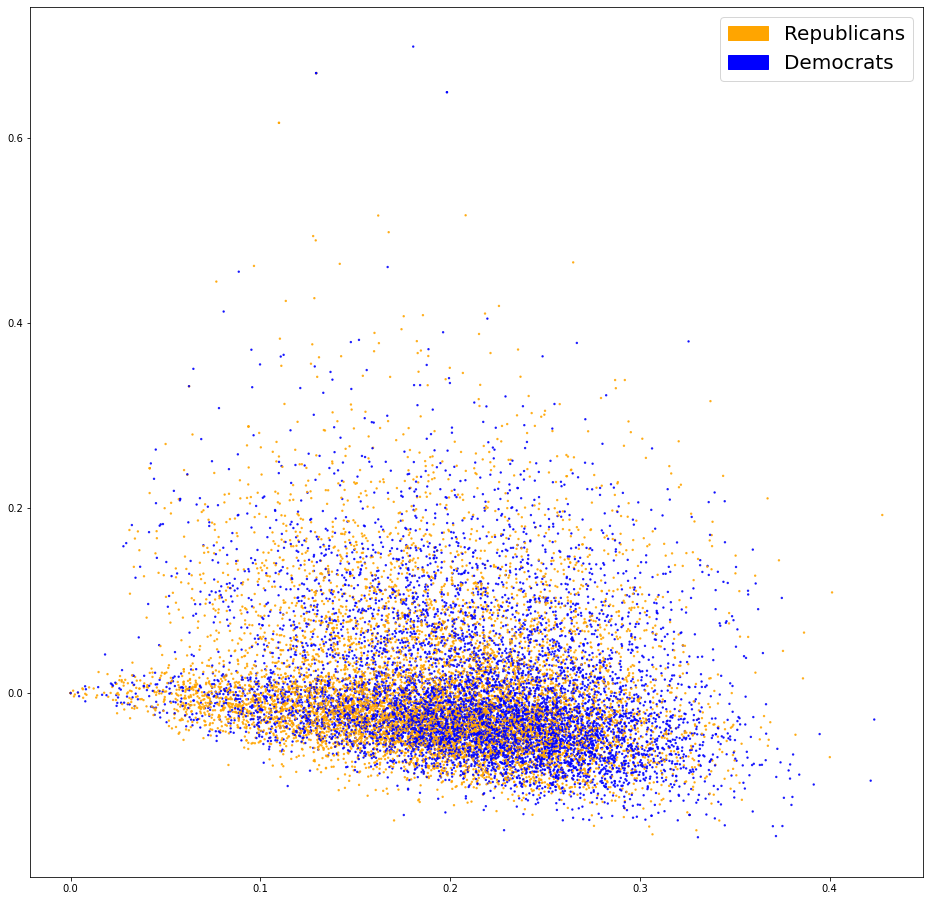

In [19]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(tfidf_train, y_train)
plt.show()

#### Considering the quantity of data we are using, let's say that these embeddings look more or less separated. Now, we check performance with a logistic regression:




In [20]:
%%time

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
log_reg.fit(tfidf_train, y_train)

y_hat = log_reg.predict(tfidf_test)

CPU times: user 31.4 ms, sys: 66.2 ms, total: 97.6 ms
Wall time: 2.5 s


#### Function to compute accuracy, precision, recall and f1 metrics

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics(y_test, y_hat): 
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_hat)

    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_hat, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_hat, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_hat, pos_label=None, average='weighted')
    

    print(f'accuracy = {accuracy}, precision = {precision}, recall = {recall}, f1 = {f1}')

In [22]:
get_metrics(y_test, y_hat)

accuracy = 0.73525, precision = 0.7355632113821138, recall = 0.73525, f1 = 0.7352123529770248


In [23]:
prop_1s = len(df[df['label_number']==1])/len(df)
print(f'Proportion of 1\'s in label_number in the dataset: {prop_1s}')

Proportion of 1's in label_number in the dataset: 0.5


#### In order to believe the value of the accuracy, per definition, it has to be bigger than the proportion of 1 in label_number in the dataset, which is correct

#### Confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_test, y_hat):
  
  conf_matrix = confusion_matrix(y_test, y_hat)
  plt.figure(figsize = (7,5))
  sns.heatmap(conf_matrix, annot=True, fmt='g');


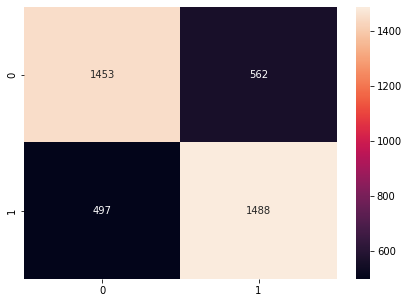

In [25]:
create_confusion_matrix(y_test, y_hat)

#### ROC Curve and area under the ROC Curve

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

def create_roc_curve(model, y_test, y_train):

  fig = plt.figure(figsize=(10, 10))          

  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(tfidf_test)[:, 1])
  plt.plot(fpr, tpr, label="Test");

  fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_train)[:, 1])
  plt.plot(fpr, tpr, label="Train");

  plt.legend(loc="lower right", prop={'size': 20});

  print(f'ROC AUC SCORE: {roc_auc_score(y_test, model.predict_proba(tfidf_test)[:, 1])}')


ROC AUC SCORE: 0.8194514691451394


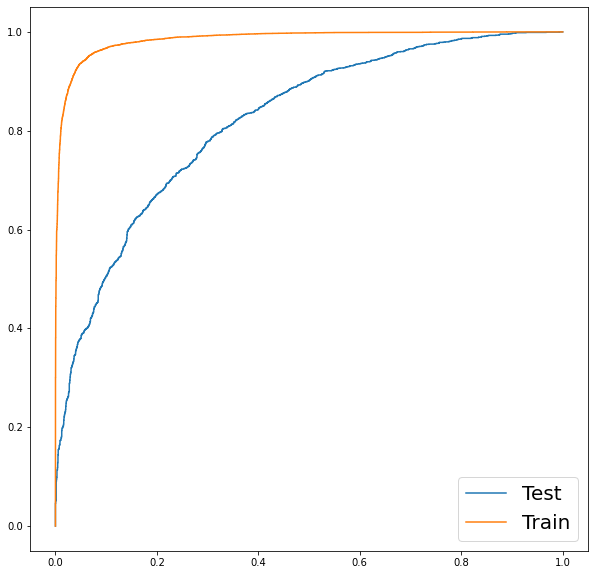

In [27]:
create_roc_curve(log_reg, y_test, y_train)

These are really good results for a first try, but we don't know if they are the best. In order to discover that, I'm going to attemp a grid search for the logistic regression.

In [28]:
param_grid = [{'penalty' : ['l1', 'l2'],
    'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'solver' : ['liblinear'],
    'max_iter' : [1000]},
    {'penalty' : ['l2'],
    'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'solver' : ['newton-cg', 'lbfgs'],
    'max_iter' : [1000]}]


In [29]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, verbose=True, n_jobs=-1)

In [30]:
%%time

best_clf = grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 696 ms, sys: 42.8 ms, total: 739 ms
Wall time: 26.2 s


In [31]:
print('Best Score: %s' % best_clf.best_score_)
print('Best Hyperparameters: %s' % best_clf.best_params_)

Best Score: 0.739875
Best Hyperparameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


In [32]:
best_model = best_clf.best_estimator_
y_hat = best_model.predict(tfidf_test)

In [33]:
get_metrics(y_test, y_hat)

accuracy = 0.7595, precision = 0.7595201645453703, recall = 0.7595, f1 = 0.7595032468157481


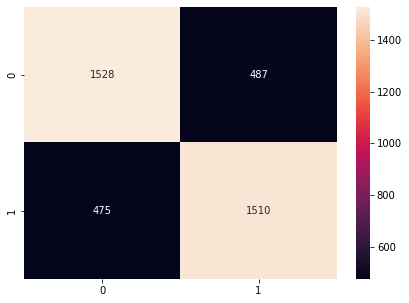

In [34]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.8356023776337419


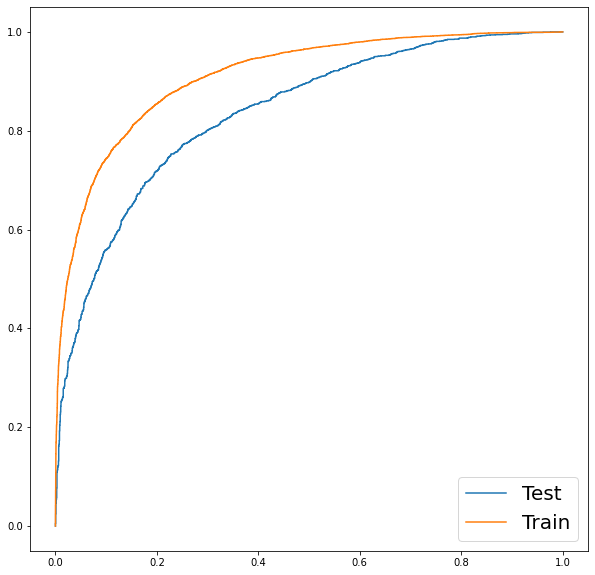

In [35]:
create_roc_curve(best_model, y_test, y_train)

#### Slightly better performance

#### Now let's try a random forest




In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
param_grid = {'bootstrap': [True],
 'max_depth': [None, 1,3,5,10],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100]}

In [38]:
grid = GridSearchCV(estimator = RandomForestClassifier(oob_score=True), param_grid = param_grid, verbose=True, n_jobs=-1)

In [39]:
%%time
best_rf_clf = grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 24 s, sys: 129 ms, total: 24.1 s
Wall time: 2min 32s


In [40]:
print('Best Score: %s' % best_rf_clf.best_score_)
print('Best Hyperparameters: %s' % best_rf_clf.best_params_)

Best Score: 0.6876875
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}


In [41]:
best_rf = best_rf_clf.best_estimator_
y_hat = best_rf.predict(tfidf_test)

In [42]:
get_metrics(y_test, y_hat)

accuracy = 0.687, precision = 0.6870068659759003, recall = 0.687, f1 = 0.6869647795754045


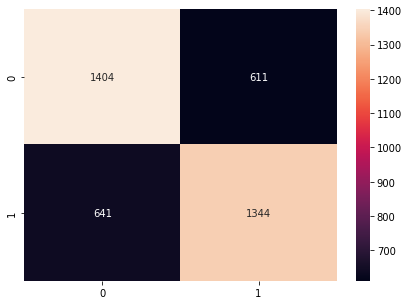

In [43]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.7574002287628678


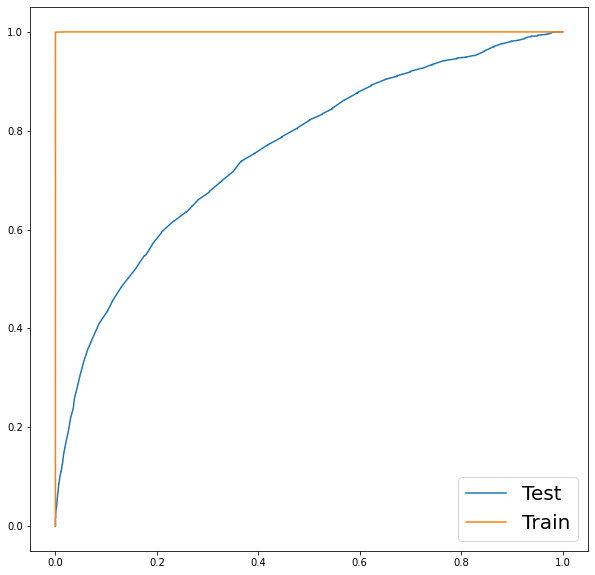

In [44]:
create_roc_curve(best_rf, y_test, y_train)

#### Although we get a slightly worst accuracy than in the logistic regression, random forest are a lot slower and show even more overfitting in the training set than the logistic regression. The logistic regression is the best model so far. But we can try some more.

#### XGBoost

In [45]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False
        )

In [46]:
%%time

xgb_model.fit(tfidf_train, y_train)

CPU times: user 10.7 s, sys: 32.5 ms, total: 10.7 s
Wall time: 10.8 s


XGBClassifier(max_depth=7, n_estimators=80, use_label_encoder=False)

In [47]:
y_hat = xgb_model.predict(tfidf_test)

In [48]:
get_metrics(y_test, y_hat)

accuracy = 0.6775, precision = 0.6779228952192478, recall = 0.6775, f1 = 0.6771790304981854


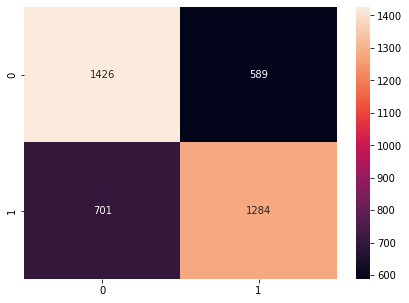

In [49]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.7563536698939315


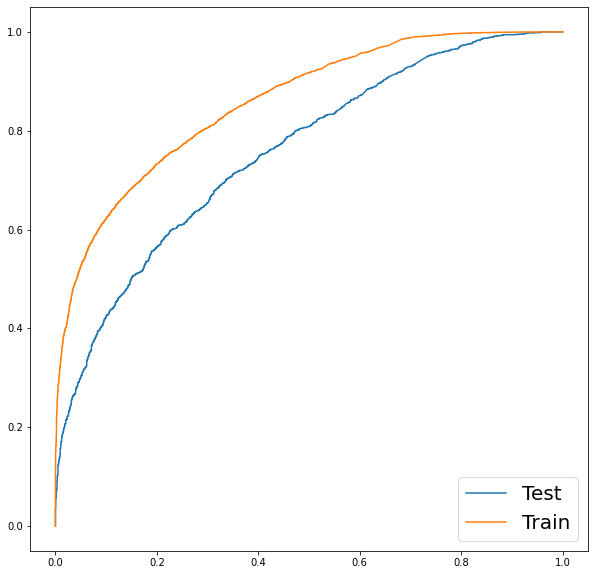

In [50]:
create_roc_curve(xgb_model, y_test, y_train)

#### Let's do a grid search for the XGBoost


In [51]:
param_grid = {
    'max_depth': [1, 3, 5, 10],
    'n_estimators': [10, 20, 40, 80],
    'learning_rate': [0.01, 0.05, 0.1],
    'booster' : ['gbtree']
    }

In [52]:
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),
    param_grid=param_grid,
    #scoring = 'roc_auc',
    n_jobs = -1,
    #cv = 10,
    verbose=True
)

In [53]:
%%time

best_xgb_clf = grid_search_xgb.fit(tfidf_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: user 29.6 s, sys: 382 ms, total: 30 s
Wall time: 11min 32s


In [54]:
print('Best Score: %s' % best_xgb_clf.best_score_)
print('Best Hyperparameters: %s' % best_xgb_clf.best_params_)

Best Score: 0.6823125000000001
Best Hyperparameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}


In [55]:
best_xgb = best_xgb_clf.best_estimator_
y_hat = best_xgb.predict(tfidf_test)

In [56]:
get_metrics(y_test, y_hat)

accuracy = 0.69375, precision = 0.694240735050768, recall = 0.69375, f1 = 0.6934403108385211


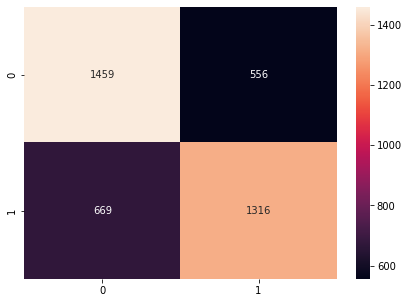

In [57]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.7654446812633211


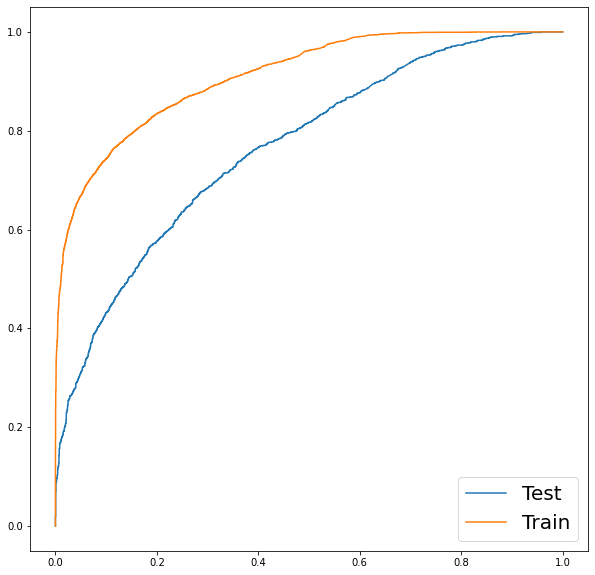

In [58]:
create_roc_curve(best_xgb, y_test, y_train)

#### This model gets an accuracy slighltly lower than logistic regression's, and it's also slower. However, it is the model which shows less overfitting in the training set so far. My conclussion is that we stick with the logistic regression.

#### BERT 

In [59]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.6 MB 6.9 MB/s 
     |████████████████████████████████| 511.7 MB 4.2 kB/s 
     |████████████████████████████████| 5.8 MB 38.1 MB/s 
     |████████████████████████████████| 438 kB 48.0 MB/s 
     |████████████████████████████████| 1.6 MB 41.3 MB/s 


In [60]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.1 MB 7.0 MB/s 
     |████████████████████████████████| 237 kB 46.2 MB/s 
     |████████████████████████████████| 92 kB 11.6 MB/s 
     |████████████████████████████████| 636 kB 44.5 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
     |████████████████████████████████| 352 kB 60.4 MB/s 
     |████████████████████████████████| 1.2 MB 57.5 MB/s 
     |████████████████████████████████| 48.3 MB 110 kB/s 
     |████████████████████████████████| 43 kB 714 kB/s 
     |████████████████████████████████| 99 kB 5.8 MB/s 


In [61]:
df_shuffled = shuffle(df)

In [62]:
len(df_shuffled)

20000

In [63]:
df_train = df_shuffled[:15999].reset_index()[['text','label_number']]
df_val = df_shuffled[16000:].reset_index()[['text','label_number']]

In [64]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer

train_text = df_train['text'].to_numpy()

tok = Tokenizer(oov_token='<unk>')
tok.fit_on_texts(train_text)
tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

train_seqs = tok.texts_to_sequences(train_text)
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

train_labels = df_train['label_number'].to_numpy().flatten()

val_text = df_val['text'].to_numpy()
val_seqs = tok.texts_to_sequences(val_text)
val_seqs = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')

val_labels = df_val['label_number'].to_numpy().flatten()

In [66]:
train_ds = tf.data.Dataset.from_tensor_slices((train_seqs, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_seqs, val_labels))

In [67]:
BATCH_SIZE = 32
train_ds_batch = train_ds.batch(BATCH_SIZE)
val_ds_batch = val_ds.batch(BATCH_SIZE)

In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_batch = train_ds_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds_batch.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
from tensorflow import keras
from tensorflow.keras import layers

vocab_size =len(tok.word_index) + 1
embedding_dim = 256

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid') # also tried activation='softmax'
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', # binary_crossentropy
              metrics=['accuracy'])

history = model.fit(
    train_ds_batch,
    epochs=3,
    validation_data=val_ds_batch, validation_steps=1, steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
)

Epoch 1/3
15999/15999 [==============================] - 64s 4ms/step - loss: 0.6399 - accuracy: 0.6417 - val_loss: 0.5706 - val_accuracy: 0.7188


#### So at first glance, BERT model is the one with worst results. 


# PENDING EXPERIMENT SOME TIME WITH THE BERT, IT SHOULD SHOW BETTER RESULTS. ALSO ADD THE PROOF THAT MORE DATA DOESN'T LEAD TO BETTER RESULTS. ALSO ADD FEATURE IMPORTANCE

#### Now, let's see the feature importance of the logistic regression

In [70]:
important_tokens = pd.DataFrame(
    data=best_model.coef_[0],
    index=vectorizer.get_feature_names(),
    columns=['Score']
).sort_values(by='Score' ,ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


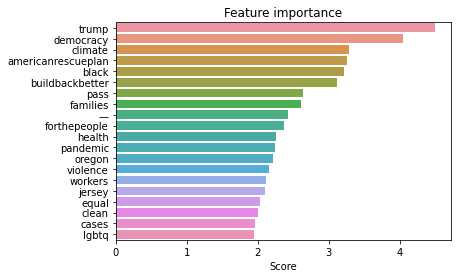

In [71]:
sns.barplot(x=important_tokens[:20]['Score'], y=important_tokens[:20].index).set_title('Feature importance');

#### Why more isn't better

In [72]:
def steps_for_lg(df_original, vectorizer, sample_size):

  print(f'Executing sample_size = {sample_size}')

  df_d = shuffle(df_original[df_original['label']=='D'])[:sample_size]
  df_r = shuffle(df_original[df_original['label']=='R'])[:sample_size]
  df = df_d.append(df_r, ignore_index=True)

  df['text_corpus'] = df['text'].apply(create_corpus_column)

  df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

  datos_X = df.text
  datos_y = df.label_number

  X_train, X_test, y_train, y_test = train_test_split(
      datos_X,
      datos_y,
      test_size = 0.2,
      random_state = 123
  )

  vectorizer.fit(X_train)

  tfidf_train = vectorizer.transform(X_train)
  tfidf_test  = vectorizer.transform(X_test)

  log_reg = LogisticRegression(C=10.0, solver='newton-cg', max_iter=1000)
  log_reg.fit(tfidf_train, y_train)

  y_hat = log_reg.predict(tfidf_test)

  accuracy = accuracy_score(y_test, y_hat)

  return accuracy

In [73]:
sample_size_list = [100, 1000, 2500, 5000, 7500, 10000, 20000, 50000, 75000, 100000, 125000, 150000, 175000, 200000]
df_compute_results = pd.DataFrame(columns=['sample_size', 'accuracy', 'time'])

In [74]:
import time

for sample_size in sample_size_list:
  start_time = time.time()
  accuracy = steps_for_lg(df_original, vectorizer, sample_size)
  finish_time = time.time() - start_time

  df_compute_results = df_compute_results.append({'sample_size': sample_size, 'accuracy': accuracy, 'time': finish_time}, ignore_index = True)

Executing sample_size = 100


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 2500


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 5000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 7500


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 10000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 20000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 50000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 75000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 100000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 125000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 150000


KeyboardInterrupt: ignored

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,5))
ax1.plot(df_compute_results['sample_size'], df_compute_results['accuracy'], color='blue', label='accuracy')
ax1.set_title('Accuracy')
ax2.plot(df_compute_results['sample_size'], df_compute_results['time'], color='orange', label='time')
ax2.set_title('Time')
plt.show()